# Yosemite Village Yearly Weather

Skye Hersh <br>
CS156 Machine Learning <br>
November 5th, 2017

In what follows, I repeat the data cleaning & preprocessing from Week 7's assignment, and re-train three ridge regression models: one on the day-of-year data, one on time-of-day, and one on both components at once. (The work is very similar to what I had before; I include it again for comparison's sake.) This time around, I completed a much stricter cross-validation scheme. Then, I repeat the process using `GPy` to try Gaussian Process modeling on the same problem — a model for each component alone and then together. Ultimately, I find very similar results using an RBF kernel with both regression methods!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from datetime import datetime
from sklearn.metrics import mean_squared_error
from __future__ import division
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

np.random.seed(101)

### Data preprocessing

In [4]:
### Load in data

path = 'yosemite-temperatures/yosemite_village/'

years = range(2011, 2017)
files = [path + 'CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % 
            y for y in years]

usecols = [3, 4, 8]

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

In [5]:
'''Make day of year and minute of day conversions'''

year = [datetime.strptime(str(int(d[0])), '%Y%m%d').
            timetuple().tm_year for d in data]

day_of_year = [datetime.strptime(str(int(d[0])), '%Y%m%d').
                timetuple().tm_yday for d in data]

time_of_day = [datetime.strptime(format(int(d[1]), '04'), 
                '%H%M') for d in data]

min_of_day = [(t.hour) * 60 + (t.minute) for t in time_of_day]

In [6]:
# Old data representation (example row 10000)
print("Old date: {}, time: {}".format(data[10000][0], 
                                      data[10000][1]))

# New data representation
print("New date: {}, time: {}".format(
    day_of_year[10000], min_of_day[10000]))

Old date: 20110204.0, time: 925.0
New date: 35, time: 565


In [7]:
'''Make dataframe for easy dropping'''

raw_df = pd.DataFrame()
raw_df['year'] = year
raw_df['day'] = day_of_year
raw_df['time'] = min_of_day
raw_df['temp'] = data[:,2]

raw_df.head()

,year,day,time,temp
0,2010,365,965,-6.4
1,2010,365,970,-6.5
2,2010,365,975,-6.5
3,2010,365,980,-6.5
4,2010,365,985,-6.7


In [8]:
'''Apparently, where there are missing temp values,
    -9999 is a placeholder. Remove these.'''

print("Old data length: {}".format(len(raw_df)))
missing_temp = raw_df[raw_df.temp == -9999.0]
df = raw_df.drop(missing_temp.index)
print("New data length: {}".format(len(df)))

Old data length: 631296
New data length: 630854


In [9]:
'''Split data into training and testing: 
training from 2011-2015 temps for prediction of 2016 temps'''

train = df[df.year.isin(range(2010, 2016))]
test = df[df.year == 2016]

X_train = train[['day', 'time']]
X_test = test[['day', 'time']]

days_train = train['day'].values.reshape(-1, 1)
days_test = test['day'].values.reshape(-1, 1)
time_train = train['time'].values.reshape(-1, 1)
time_test = test['time'].values.reshape(-1, 1)
y_train = train['temp'].values.reshape(-1, 1)
y_test = test['temp'].values.reshape(-1, 1)

## Linear parameter modeling

My ridge regression: in the previous iteration of this assignment, I dubiously eyeballed the ridge regression's fit in order to arrive at solid hyperparameters. For this second time around, I've cross validated over some options in order to be a bit more rigorous!

In [10]:
from sklearn.model_selection import ParameterGrid, cross_val_score

def grid_cross_val(X, y, component, verbose=False):
    '''Cross validate over alpha, sigma, and no. of
        centers to find semi-optimal values (depending
        on component passed — days or time)'''
    
    if component == 'days':

        centers = [np.linspace(1, 366, x).reshape(-1, 1) 
                       for x in [5, 10, 20, 50]] 
        
    elif component == 'time':
        
        centers = [np.linspace(1, 1435, x).reshape(-1, 1) 
               for x in [5, 10, 20, 50]] 

    sigmas = [5, 50, 500, 5000]
    alphas = [0.01, 0.1, 1.0, 10.]

    param_grid = {'center': centers, 
                  'sigma': sigmas, 
                  'alpha': alphas,
                 }

    errors = []
    scores_list = []
    cv = 3

    for param_option in ParameterGrid(param_grid):

        center = param_option['center']
        sigma = param_option['sigma']
        alpha = param_option['alpha']

        rbf = rbf_kernel(X=X, Y=center, gamma=1./sigma)
        regr = Ridge(alpha=alpha, fit_intercept=True)

        scores = cross_val_score(regr, rbf, y_train, 
                                 scoring='neg_mean_squared_error',
                                 cv=cv)

        if verbose is True:
            # Print scores for each set of parameters
            print("No. centers: {}, sigma: {}, alpha: {}".format(
                            len(center), sigma, alpha))
            print("\t Cross validated MSE: %0.2f (+/- %0.2f)" % 
                  (-scores.mean(), scores.std() * 2))
            print

        errors.append(-scores.mean())
        scores_list.append(scores)

    lowest_err = np.argmin(errors)
    winner = ParameterGrid(param_grid)[lowest_err]
    print("Best hyperparameters found w/ cross validation:")
    print("\t No. centers: {}".format(len(winner['center'])))
    print("\t Sigma: {}".format(winner['sigma']))
    print("\t Alpha: {}".format(winner['alpha']))
    mse = scores_list[lowest_err]
    print("\t Cross validated MSE: %0.2f (+/- %0.2f)" % 
        (-mse.mean(), mse.std() * 2))

In [174]:
print("CROSS VALIDATION FOR DAYS COMPONENT PARAMETERS:")
grid_cross_val(X=days_train, y=y_train, component='days')

CROSS VALIDATION FOR DAYS COMPONENT PARAMETERS:
Best hyperparameters found w/ cross validation:
	 No. centers: 10
	 Sigma: 5000
	 Alpha: 10.0
	 Cross validated MSE: 28.72 (+/- 4.30)


In [175]:
print("CROSS VALIDATION FOR TIME COMPONENT PARAMETERS:")
grid_cross_val(X=time_train, y=y_train, component='time')

CROSS VALIDATION FOR TIME COMPONENT PARAMETERS:
Best hyperparameters found w/ cross validation:
	 No. centers: 50
	 Sigma: 5000
	 Alpha: 0.1
	 Cross validated MSE: 60.19 (+/- 6.80)


I'll stick with these as my parameters!

## Individual components, ridge regression

In [11]:
### Establish hyperparameters to use throughout
### (taken from cross val results above)

d_centers = np.linspace(1, 366, 10).reshape(-1, 1)
t_centers = np.linspace(0, 1435, 50).reshape(-1, 1)

d_alpha = 10.0
t_alpha = 0.1

sigma = 5000 # same for both

In [12]:
### Just contribution of days component

rbf_train_days = rbf_kernel(days_train, d_centers, gamma=1./sigma)
rbf_test_days = rbf_kernel(days_test, d_centers, gamma=1./sigma)

regr_days = Ridge(alpha=d_alpha, fit_intercept=True)

t0 = time.time()
regr_days.fit(rbf_train_days, y_train)
t1 = time.time()

days_train_pred = regr_days.predict(rbf_train_days)
days_test_pred = regr_days.predict(rbf_test_days)

print("Ridge regression, DAYS only")
print("\t Training time: %.5f" % (t1 - t0))

print("\t MSE on train data: {}".format(
    mean_squared_error(y_train, days_train_pred)))

print("\t MSE on test data: {}".format(
    mean_squared_error(y_test, days_test_pred)))

Ridge regression, DAYS only
	 Training time: 0.14128
	 MSE on train data: 26.4579651115
	 MSE on test data: 25.6530783728


In [13]:
### Just contribution of time component

rbf_train_time = rbf_kernel(time_train, t_centers, 1/sigma)
rbf_test_time = rbf_kernel(time_test, t_centers, 1/sigma)

regr_time = Ridge(alpha=t_alpha, fit_intercept=True)

t0 = time.time()
regr_time.fit(rbf_train_time, y_train)
t1 = time.time()

time_train_pred = regr_time.predict(rbf_train_time)
time_test_pred = regr_time.predict(rbf_test_time)

print("Ridge regression, TIME only")
print("\t Training time: %.5f" % (t1 - t0))

print("\t MSE on train data: {}".format(
    mean_squared_error(y_train, time_train_pred)))

print("\t MSE on test data: {}".format(
    mean_squared_error(y_test, time_test_pred)))

Ridge regression, TIME only
	 Training time: 0.52962
	 MSE on train data: 58.554101052
	 MSE on test data: 57.8453139955


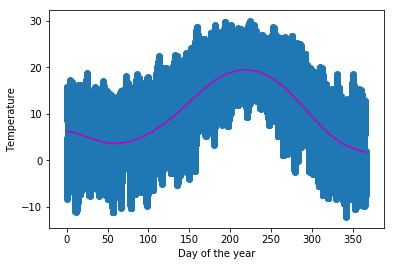

In [14]:
all_days = np.linspace(0, 366, 1000).reshape(-1, 1)

expanded_rbf_days = rbf_kernel(all_days, d_centers, 
                               gamma = 1/sigma)

all_days_y = regr_days.predict(expanded_rbf_days)

plt.figure()
plt.xlabel('Day of the year')
plt.ylabel('Temperature')
plt.plot(all_days, all_days_y, 'm')
plt.scatter(days_train, y_train)
plt.show()

This curve is much smoother than my last attempt — cross validating rigorously counts for something!

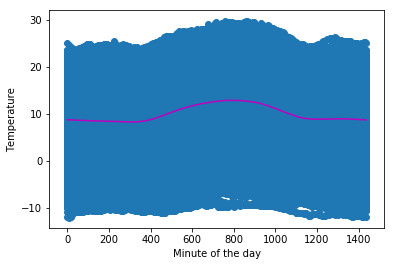

In [20]:
all_times = np.linspace(0, 1435, 1000).reshape(-1, 1)

expanded_rbf_times = rbf_kernel(all_times, t_centers, 
                                gamma = 1.0/sigma)

all_times_y = regr_time.predict(expanded_rbf_times)

plt.figure()
plt.xlabel('Minute of the day')
plt.ylabel('Temperature')
plt.plot(all_times, all_times_y, 'm')
plt.scatter(time_train, y_train)
plt.show()


### Both components

Now, we'll look at both components — day of year and time of day — together.

In [21]:
def make_rbf(days, day_centers, day_sigma,  
             mins, min_centers, min_sigma):
    
    '''Returns an rbf_array output for both components'''
    
    day_rbf = np.array(rbf_kernel(days, day_centers, gamma = 1/day_sigma))
    min_rbf = np.array(rbf_kernel(mins, min_centers, gamma = 1/min_sigma))
    
    rbf_array = np.concatenate((day_rbf, min_rbf), axis=1)
    print("RBF array shape: {}".format(rbf_array.shape))

    return rbf_array

In [24]:
print("Training:")
rbf_train = make_rbf(days_train, d_centers, sigma, 
                     time_train, t_centers, sigma)

print("Testing:")
rbf_test = make_rbf(days_test, d_centers, sigma, 
                    time_test, t_centers, sigma)

Training:
RBF array shape: (525575, 60)
Testing:
RBF array shape: (105279, 60)


In [25]:
regr = Ridge(alpha=0.01, fit_intercept=True)

t0 = time.time()
regr.fit(rbf_train, y_train)
t1 = time.time()

train_pred = regr.predict(rbf_train)
test_pred = regr.predict(rbf_test)

print("Ridge regression, DAYS and TIME")
print("\t Training time: %.5f" % (t1 - t0))
print("\t MSE on test data: {}".format(mean_squared_error(y_test, test_pred)))
print("\t MSE on test data: {}".format(mean_squared_error(y_train, train_pred)))

Ridge regression, DAYS and TIME
	 Training time: 0.87550
	 MSE on test data: 23.321070174
	 MSE on test data: 23.6379218908


## Plotting — both components

In [26]:
def make_surface(days_meshgrid, day_centers, day_sigma, 
                 min_meshgrid, min_centers, min_sigma, ridge):

    expanded_days = np.array(rbf_kernel(days_meshgrid[:,0].reshape(-1, 1), 
                                        day_centers, gamma=1.0/day_sigma))
    
    expanded_mins = np.array(rbf_kernel(min_meshgrid[0].reshape(-1, 1), 
                                        min_centers, gamma=1.0/min_sigma))
    
    expanded_2D = []
    
    for i in xrange(len(expanded_days)):
        for j in xrange(len(expanded_mins)):
            expanded_2D.append(np.hstack((expanded_days[i], expanded_mins[j])))

    pred = ridge.predict(expanded_2D)
    all_y = pred.reshape(200, 200)
    
    return all_y

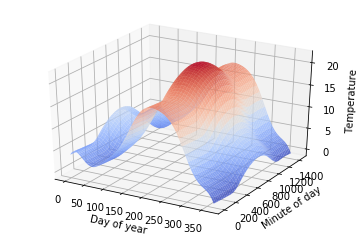

In [29]:
all_days = np.linspace(0.0, 366.0, 200)
all_mins = np.linspace(0.0, 1435.0, 200)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('Day of year') 
ax.set_ylabel('Minute of day')
ax.set_zlabel('Temperature')

m_mesh, d_mesh = np.meshgrid(all_mins, all_days)

Z = make_surface(d_mesh, d_centers, sigma, 
                 m_mesh, t_centers, sigma, regr)

surface = ax.plot_surface(d_mesh, m_mesh, Z, 
                          cmap=cm.coolwarm, 
                          alpha=0.8)

plt.show()

# Gaussian Process modeling

Now, I'll try approaching the same problem with a Gaussian Process. As is clear below, I didn't cross-validate for any hyperparameters (doing so would be very time-intensive), but I used `GPy`'s built-in `optimize` method to find ideal kernel parameters. In the spirit of a controlled comparison, I just stuck with an RBF kernel, which does the trick: there are a diverse range of covariance functions available (through `GPy`), but I don't actually think that this problem requires anything else: the curves for both day-of-year and time-of-day are fairly simple — roughly symmetrical, with one bump in the middle. In light of this simplicity, I use only 20 inducing points for day-of-year and 50 for time-of-day: there isn't really nuance to the function that the GP needs to learn.

In [35]:
import GPy
%matplotlib inline

## One component at a time

In [33]:
### GAUSSIAN PROCESS FOR DAY-OF-YEAR

noise_var = 0.05
num_ind = 20
k = GPy.kern.RBF(1)

t0 = time.time()
m_days = GPy.models.SparseGPRegression(days_train, 
                                       y_train, 
                                       kernel=k, 
                                       num_inducing=num_ind,
                                      )
t1 = time.time()

m_days.likelihood.variance = noise_var
m_days.inducing_inputs.fix() # Just to speed things up
m_days.optimize('bfgs')
t2 = time.time()

print("GP training time: %0.3f" % (t1 - t0))
print("GP optimization time: %0.3f" % (t2 - t1))
print m_days

GP training time: 2.047
GP optimization time: 74.330

Name : sparse_gp
Objective : 1601235.79185
Number of Parameters : 23
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |          value  |  constraints  |  priors
  inducing_inputs          |        (20, 1)  |     fixed     |        
  rbf.variance             |  1.45012454182  |      +ve      |        
  rbf.lengthscale          |   19.487261796  |      +ve      |        
  Gaussian_noise.variance  |  25.8757584564  |      +ve      |        


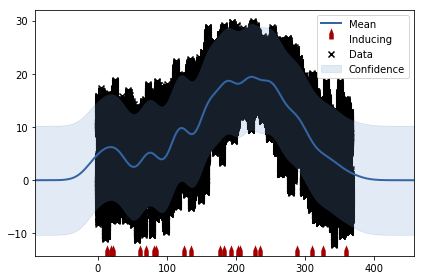

In [37]:
m_days.plot();

In [41]:
### GAUSSIAN PROCESS FOR MINUTES-OF-DAY

noise_var = 0.05
num_ind = 20
k = GPy.kern.RBF(1)

t0 = time.time()
m_mins = GPy.models.SparseGPRegression(time_train, 
                                       y_train, 
                                       kernel=k, 
                                       num_inducing=num_ind,
                                      )
print("Done making GP")
t1 = time.time()

m_mins.likelihood.variance = noise_var

m_mins.inducing_inputs.fix() # Again, for the love of the lord, just to speed this up
m_mins.optimize('bfgs')
t2 = time.time()

print("GP training time: %0.3f" % (t1 - t0))
print("GP optimization time: %0.3f" % (t2 - t1))
print m_mins

Done making GP
GP training time: 2.124
GP optimization time: 155.403

Name : sparse_gp
Objective : 1815349.12182
Number of Parameters : 23
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |          value  |  constraints  |  priors
  inducing_inputs          |        (20, 1)  |     fixed     |        
  rbf.variance             |  46.0025176714  |      +ve      |        
  rbf.lengthscale          |   256.59772991  |      +ve      |        
  Gaussian_noise.variance  |  58.5567223629  |      +ve      |        


In [43]:
days_train_pred = m_days.predict(days_train)
days_test_pred = m_days.predict(days_test)

mins_train_pred = m_mins.predict(time_train)
mins_test_pred = m_mins.predict(time_test)

print("GP MSE on train data, DAYS ONLY: {}".format(
    mean_squared_error(y_train, days_train_pred[0])))

print("GP MSE on test data, DAYS ONLY: {}".format(
    mean_squared_error(y_test, days_test_pred[0])))

print
print("GP MSE on train data, TIME ONLY: {}".format(
    mean_squared_error(y_train, mins_train_pred[0])))

print("GP MSE on test data, TIME ONLY: {}".format(
    mean_squared_error(y_test, mins_test_pred[0])))

GP MSE on train data, DAYS ONLY: 25.8269425009
GP MSE on test data, DAYS ONLY: 27.1191689367

GP MSE on train data, TIME ONLY: 58.5551951018
GP MSE on test data, TIME ONLY: 57.8465131992


These scores are remarkably similar to that which we saw with the ridge regression. I wonder whether it's possible to do much better than this at all.

## Gaussian Process, both components at once

Below, you'll see that I set lengthscale to 100; I was finding that if I didn't, it was taking far too long to learn that lengthscale should be relatively large.

In [50]:
X_train_arr = X_train.as_matrix()
X_test_arr = X_test.as_matrix()

k2 = GPy.kern.RBF(2, lengthscale=100)

t0 = time.time()
m_both = GPy.models.SparseGPRegression(X_train_arr, 
                                       y_train, 
                                       kernel=k2, 
                                       num_inducing=20,
                                      )
t1 = time.time()

m_both.likelihood.variance = noise_var

m_both.inducing_inputs.fix()
m_both.optimize('bfgs')
t2 = time.time()

print("GP training time: %0.3f" % (t1 - t0))
print("GP optimization time: %0.3f" % (t2 - t1))
print m_both

GP training time: 2.561
GP optimization time: 253.464

Name : sparse_gp
Objective : 1615729.51196
Number of Parameters : 43
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |          value  |  constraints  |  priors
  inducing_inputs          |        (20, 2)  |     fixed     |        
  rbf.variance             |  7877.80931274  |      +ve      |        
  rbf.lengthscale          |  653.586176198  |      +ve      |        
  Gaussian_noise.variance  |  27.4213157084  |      +ve      |        


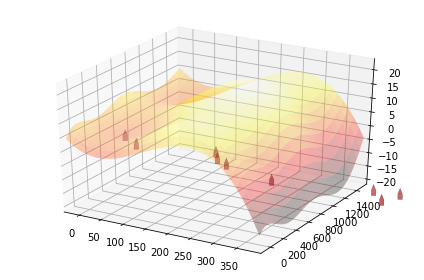

In [51]:
m_both.plot(plot_data=False, projection='3d', legend=False)

In [52]:
both_train_pred = m_both.predict(X_train_arr)
both_test_pred = m_both.predict(X_test_arr)

print("GP MSE on train data, DAYS & TIME: {}".format(
    mean_squared_error(y_train, both_train_pred[0])))

print("GP MSE on train data, DAYS & TIME: {}".format(
    mean_squared_error(y_test, both_test_pred[0])))

GP MSE on train data, DAYS & TIME: 27.3109757459
GP MSE on train data, DAYS & TIME: 26.4504250124


Again, very similar performance to that of the 2D ridge regression. But notably, I ran the GP a few times, and I'm finding it quite sensitive to initial conditions. I only use 20 inducing points, and surely this has something to do with the inconsistency: the model learns from quite different points each time. I could use more inducing points, but optimization time is becoming more trouble than it's worth. 

Ultimately, as the performance on the two regression methods is nearly identical, I'd conclude that ridge regression is sufficient for this problem: it took less time to cross-validate for nearly optimal hyperparameters than it does for `GPy` to optimize. 